In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from collections import OrderedDict
import Autoencoder as AE

# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Reproducibility  
torch.manual_seed(0);

C:\Users\dstre\AppData\Local\Temp\ipykernel_28244\2062129741.py:5: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  import matplotlib.pyplot as plt


In [2]:
### Load Data ### 

#Use create a transform that uses bilinear interpolation to resize images to 64 square
im_size = 64
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(im_size),
    torchvision.transforms.ToTensor()
])

#load dataset and init dataloader (THIS WILL DOWNLOAD THE DATASET)
#dataloader will automatically batch and handle data
#The MNIST dataset is "premade," we will likely need to use TensorDataset to load our own datasets
mnist_dset_train = torchvision.datasets.MNIST(root = './data/', download=True, train = True, transform = transform)
batch_size = 128
mnist_DL = torch.utils.data.DataLoader(mnist_dset_train, shuffle=True, batch_size=batch_size) 

Image batch: torch.Size([128, 1, 64, 64])


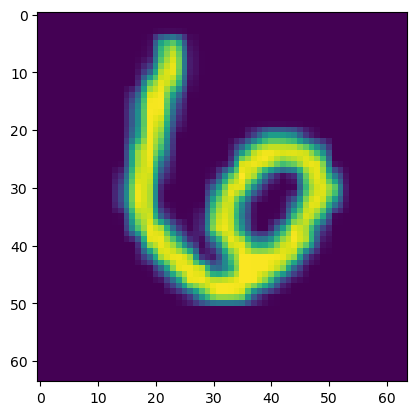

In [3]:
#show sample
sample = next(iter(mnist_DL))  #grab the next batch from the dataloader
print('Image batch:', sample[0].shape) #of shape batch_size x channels x W x H (channels = 1 for this grayscale dset)  
plt.imshow(sample[0][0,0])    #show the image
plt.show()

In [4]:
#initialize and test networks 
#make sure to send everything to the correct device (important if you have GPU)
n_latent = int(0.1 * (im_size**2)) #number of latent variables (10% of the input size)
n_hidden = 5 #number of hidden layers 
NN_width = 128 #width of the hidden layers

net = AE.AutoEncoder(im_size, n_latent, n_hidden, NN_width).to(device)
reconst, latent = net(sample[0].to(device))
print('Reconstructed shape:', reconst.shape)
print('Latent shape:', latent.shape)

Reconstructed shape: torch.Size([128, 1, 64, 64])
Latent shape: torch.Size([128, 409])


In [5]:
#training parameters
epochs = 3        #one epoch is one iteration through the entire training cylce
iters_cycle = 100    #frequency of which to log results
error = torch.nn.MSELoss() 

In [6]:
### Train Autoencoder ###
LR = 0.001

#initialize error function and optimizer
opt = torch.optim.Adam(net.parameters(), betas=(0.5, 0.999), lr = LR)

#save losses
losses = []

#train
iters = 0

for epoch in range(epochs):
    #iterate through dataloader
    for batch in mnist_DL:
        #separate batch into labels and images
        images = batch[0].to(device)
        
        #make predictions
        reconst, latent = net(images)
        
        #calculate loss
        loss = error(reconst, images)
        
        #backpropagate gradients with Adam algorithm, this is the magic of pytorch and autograd
        loss.backward()
        opt.step()
        
        #reset gradients
        net.zero_grad()
        
        #save losses
        losses.append(loss.item())
        
        #log progress
        if iters%iters_cycle==0:    
            print('Epoch: {}/{}     Iter: {}     Loss: {}'.format(epoch, epochs, iters, loss.item()))
        iters +=1

Epoch: 0/3     Iter: 0     Loss: 0.21997973322868347
Epoch: 0/3     Iter: 100     Loss: 0.05214330554008484
Epoch: 0/3     Iter: 200     Loss: 0.05131731554865837
Epoch: 0/3     Iter: 300     Loss: 0.05002596974372864
Epoch: 0/3     Iter: 400     Loss: 0.05051048472523689
Epoch: 1/3     Iter: 500     Loss: 0.04758549854159355
Epoch: 1/3     Iter: 600     Loss: 0.045174937695264816
Epoch: 1/3     Iter: 700     Loss: 0.042331255972385406
Epoch: 1/3     Iter: 800     Loss: 0.04300215095281601
Epoch: 1/3     Iter: 900     Loss: 0.04366335645318031
Epoch: 2/3     Iter: 1000     Loss: 0.03923087567090988
Epoch: 2/3     Iter: 1100     Loss: 0.035791222006082535
Epoch: 2/3     Iter: 1200     Loss: 0.03515835851430893
Epoch: 2/3     Iter: 1300     Loss: 0.03451310843229294
Epoch: 2/3     Iter: 1400     Loss: 0.033633630722761154


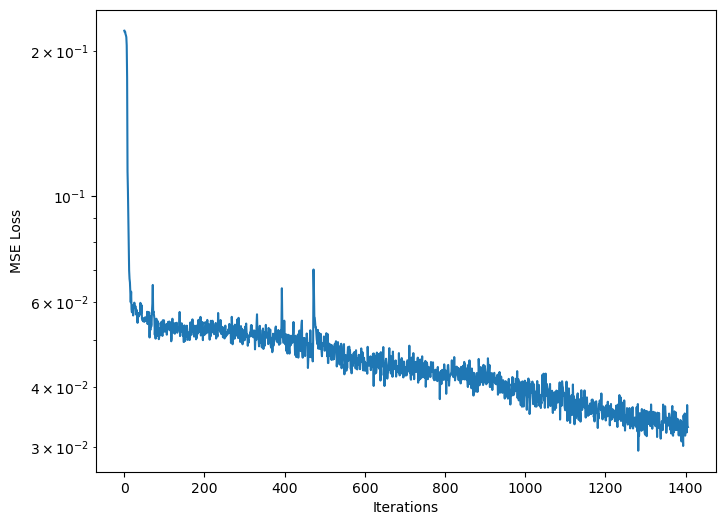

In [7]:
#plot loss curve 
plt.figure(figsize = (8,6))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.show()

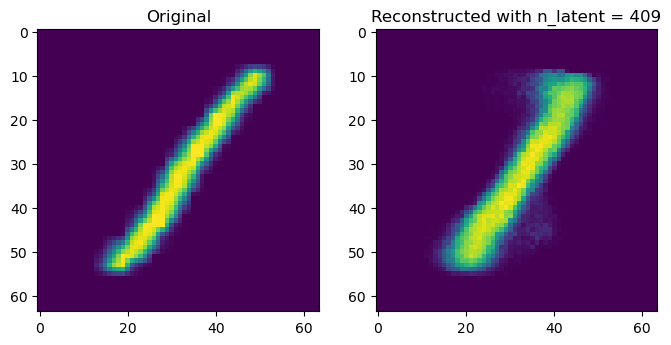

Reconstruction Error:  0.033450897783041


In [13]:
#Create test dataset and load into dataloader
mnist_dset_test = torchvision.datasets.MNIST(root = './data/MNIST/', download=True, train = False, transform = transform)
num_samples = 500
mnist_DL_test = torch.utils.data.DataLoader(mnist_dset_test, shuffle=True, batch_size=num_samples)

#display sample with label and prediction
sample = next(iter(mnist_DL_test))
reconst, latent = net(sample[0].to(device))

# show image and reconstruction side by side 
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(sample[0][0,0])
ax[0].set_title('Original')
ax[1].imshow(reconst[0,0].detach().cpu())
ax[1].set_title('Reconstructed with n_latent = ' + str(n_latent))
plt.show()

print("Reconstruction Error: ", error(reconst, sample[0].to(device)).item())
